does this work?This notebook will outline how to run crobat once installed
The Steps we will take:
 - Step 0: preliminaries, setting the directory so we can import crobatd
 - Step 1: Imports and Defining the Settings class 
 - Step 2: constructing the websocket connection
 - Step 3: verifying file contents
 - Step 4: Simple Visualzation

In [1]:
import os, sys
os.chdir('../..')
#os.chdir('..') # moves us 2 folders back into to allow for imports that users would use
wd = os.getcwd()
print(wd)
sys.path.append(wd)
#print(os.getcwd())
for i in sys.path:
    print(i)


/home/ivan/Documents/github
/home/ivan/Documents/github/crobat/Jupyter nbs
/home/ivan/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/vscode_datascience_helpers
/home/ivan/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles
/home/ivan/.vscode/extensions/ms-toolsai.jupyter-2021.6.999662501/pythonFiles/lib/python
/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload

/home/ivan/.local/lib/python3.8/site-packages
/usr/local/lib/python3.8/dist-packages
/usr/lib/python3/dist-packages
/home/ivan/.local/lib/python3.8/site-packages/IPython/extensions
/home/ivan/.ipython
/home/ivan/Documents/github


In [2]:
# Step 1 Lets try imports
# Step 1 :  crobat.crobat this will bring in the crobat and the classes we need
# lets take a look at it
from crobat.crobat import recorder as rec
from copra.websocket import Channel, Client

In [3]:
# Step 1 : defining settings class
class input_args(object):
    def __init__(self, currency_pair='ETH-USD',
                       position_range=5,
                       recording_duration=5,
                       sides=['bid','ask'],
                       filetype=['xlsx']):
    
        self.currency_pair = currency_pair
        self.position_range = position_range
        self.recording_duration = recording_duration
        self.sides = sides
        self.filetype = filetype
settings = input_args()
print(dir(settings))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'currency_pair', 'filetype', 'position_range', 'recording_duration', 'sides']


In [4]:
# step 2 constructing the ws connection
import asyncio
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()
channel = Channel('level2', settings.currency_pair) 
channel2 =Channel('ticker', settings.currency_pair)
ws = rec.L2_Update(loop, channel, settings)
ws.subscribe(channel2)
try:
    loop.run_forever()
except KeyboardInterrupt:
    loop.run_until_complete(ws.close())
    loop.close()

Let's count the L2 messages! 2021-07-08 15:14:22.207665
received the snapshot
dropping connection to peer tcp4:104.18.15.237:443 with abort=True: WebSocket closing handshake timeout (peer did not finish the closing handshake in time)
Connection to server is closed
False
1006
connection was closed uncleanly (WebSocket closing handshake timeout (peer did not finish the closing handshake in time))
recorded the time
found bid okay
added events okay


SystemExit: 

In [11]:
# lets take a look at the output files
import pandas as pd 
#print(os.listdir())
for i in os.listdir():
    if i.endswith(".xlsx"):
        print(i)
        df = pd.read_excel(i)
        print(df.head())

L2_orderbook_volm_bid2021-07-08 15:14:36.925748.xlsx
   Unnamed: 0                    time         1         2         3  \
0           1 2021-07-08 15:14:22.570  0.344403  1.249916  0.474400   
1           2 2021-07-08 15:14:22.570  0.344403  0.342916  0.474400   
2           3 2021-07-08 15:14:22.575  0.344403  0.342916  0.474400   
3           4 2021-07-08 15:14:22.595  0.344403  0.474400  1.724293   
4           5 2021-07-08 15:14:22.689  0.474400  1.724293  9.961813   

            4           5  
0    0.474400    1.724293  
1    0.474400    1.724293  
2    1.724293    9.961813  
3    9.961813  252.191878  
4  252.191878   11.554000  
L2_orderbook_volm_ask2021-07-08 15:14:36.925748.xlsx
   Unnamed: 0                    time      1         2         3      4  \
0           1 2021-07-08 15:14:22.566  4.647  2.454347  0.744000  2.500   
1           2 2021-07-08 15:14:22.686  0.744  4.647000  2.454347  0.744   
2           3 2021-07-08 15:14:22.694  0.744  5.391000  2.454347  0.744   

   Unnamed: 0                       0            1        2         3  4  \
0           1 2021-07-08 15:14:22.570  cancelation  2162.37  0.907000  2   
1           2 2021-07-08 15:14:22.575  cancelation  2162.33  0.474400  4   
2           3 2021-07-08 15:14:22.595  cancelation  2162.37  0.342916  2   
3           4 2021-07-08 15:14:22.689  cancelation  2162.38  0.344403  1   
4           5 2021-07-08 15:14:22.711    insertion  2162.35  0.344291  1   

          5     6  
0  2162.490  0.22  
1  2162.490  0.22  
2  2162.490  0.22  
3  2162.465  0.25  
4  2162.470  0.24  


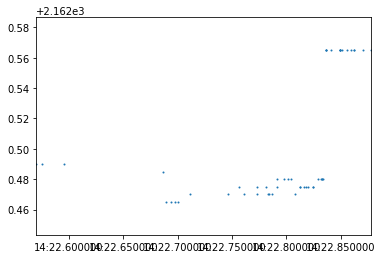

In [23]:
# visualizing the events
import matplotlib.pyplot as plt
# add the mid price to the events as the the plotting of the concatenation of bid and as events
bid_events = pd.read_excel('L2_orderbook_events_bid2021-07-08 15:14:36.925748.xlsx')
ask_events = pd.read_excel('L2_orderbook_events_ask2021-07-08 15:14:36.925748.xlsx')
print(bid_events.head())
all_events = pd.concat([bid_events, ask_events])

plt.scatter(all_events[0], all_events[5], s=1)
plt.xlim(all_events[0].iloc[0], all_events[0].iloc[-1])
plt.ylim(min(all_events[5])*0.99999, max(all_events[5])*1.00001)
plt.show()

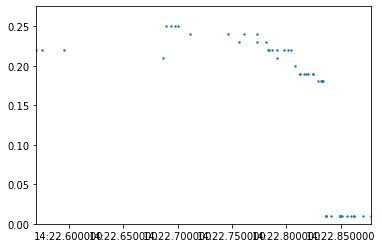

In [35]:
# bid ask spread
plt.scatter(all_events[0], all_events[6], s=2)
plt.xlim(all_events[0].iloc[0], all_events[0].iloc[-1])
plt.ylim(0, max(all_events[6])*1.1)
plt.show()
# historgram of orders dsand their sizes
# market depth timeseries

In [53]:
# market depth
bid_volms = pd.read_excel('L2_orderbook_volm_bid2021-07-08 15:14:36.925748.xlsx')
bid_prices = pd.read_excel('L2_orderbook_prices_bid2021-07-08 15:14:36.925748.xlsx')
ask_volms = pd.read_excel('L2_orderbook_volm_ask2021-07-08 15:14:36.925748.xlsx')
ask_prices = pd.read_excel('L2_orderbook_prices_ask2021-07-08 15:14:36.925748.xlsx')
df_depth_bid = bid_volms.copy()
#print(bid_volms.head())
#print(bid_prices.head())
df_depth_bid['1'] = df_depth_bid['1'].mul(bid_prices['1'])
df_depth_bid['2'] = df_depth_bid['2'].mul(bid_prices['2'])
df_depth_bid['3'] = df_depth_bid['3'].mul(bid_prices['3'])
df_depth_bid['4'] = df_depth_bid['4'].mul(bid_prices['4'])
df_depth_bid['5'] = df_depth_bid['5'].mul(bid_prices['5'])
print(df_depth_bid.head())

df_depth_ask = ask_volms.copy()
#print(bid_volms.head())
#print(bid_prices.head())
df_depth_ask['1'] = df_depth_ask['1'].mul(ask_prices['1'])
df_depth_ask['2'] = df_depth_ask['2'].mul(ask_prices['2'])
df_depth_ask['3'] = df_depth_ask['3'].mul(ask_prices['3'])
df_depth_ask['4'] = df_depth_ask['4'].mul(ask_prices['4'])
df_depth_ask['5'] = df_depth_ask['5'].mul(ask_prices['5'])
print(df_depth_ask.head())


   Unnamed: 0                    time            1            2             3  \
0           1 2021-07-08 15:14:22.570   744.730159  2702.780861   1025.814096   
1           2 2021-07-08 15:14:22.570   744.730159   741.511271   1025.814096   
2           3 2021-07-08 15:14:22.575   744.730159   741.511271   1025.814096   
3           4 2021-07-08 15:14:22.595   744.730159  1025.814096   3728.455997   
4           5 2021-07-08 15:14:22.689  1025.814096  3728.455997  21540.428250   

               4              5  
0    1025.809352    3728.455997  
1    1025.809352    3728.455997  
2    3728.455997   21540.428250  
3   21540.428250  545311.975881  
4  545311.975881   24981.365560  
   Unnamed: 0                    time            1             2            3  \
0           1 2021-07-08 15:14:22.566  10049.60220   5307.795366  1608.989280   
1           2 2021-07-08 15:14:22.686   1608.96696  10049.602200  5307.795366   
2           3 2021-07-08 15:14:22.694   1608.96696  11658.576600  

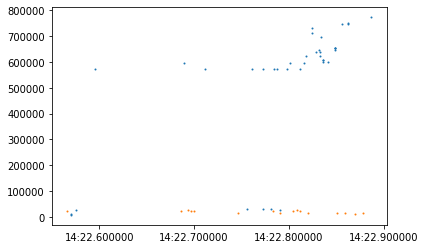

In [55]:
# plotting ask and bid depth 
df_depth_bid['sum'] = df_depth_bid['1'] + df_depth_bid['2'] + df_depth_bid['3'] + df_depth_bid['4'] + df_depth_bid['5']
df_depth_ask['sum'] = df_depth_ask['1'] + df_depth_ask['2'] + df_depth_ask['3'] + df_depth_ask['4'] + df_depth_ask['5']
plt.scatter(df_depth_bid['time'], df_depth_bid['sum'], s=1)
plt.scatter(df_depth_ask['time'], df_depth_ask['sum'], s=1)
plt.show()

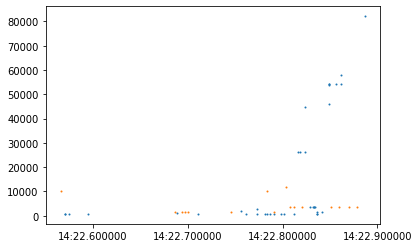

In [57]:
# plotting ask and bid depth 
plt.scatter(df_depth_bid['time'], df_depth_bid['1'], s=1)
plt.scatter(df_depth_ask['time'], df_depth_ask['1'], s=1)
plt.show()

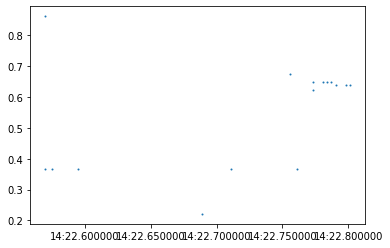

In [56]:
# orderbook imbalance 
plt.scatter(df_depth_bid['time'], (df_depth_ask['1'] - df_depth_bid['1'])/(df_depth_ask['1'] + df_depth_bid['1']), s=1)
plt.show()
# note there imbalance only gets computed when there the timestamps are identical, since the books are assumed indpendent
# it is a sparse coincidence that these things are computed